In [24]:
import numpy as np
import pandas as pd
import math
from apyori import apriori

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans 

In [2]:
df=pd.read_csv('Laundry_Data.csv')

# Data Cleaning

In [3]:
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 807 entries, 0 to 806
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   No             807 non-null    int64  
 1   Date           807 non-null    object 
 2   Time           807 non-null    object 
 3   Race           752 non-null    object 
 4   Gender         716 non-null    object 
 5   Body_Size      709 non-null    object 
 6   Age_Range      756 non-null    float64
 7   With_Kids      725 non-null    object 
 8   Kids_Category  777 non-null    object 
 9   Basket_Size    752 non-null    object 
 10  Basket_colour  717 non-null    object 
 11  Attire         776 non-null    object 
 12  Shirt_Colour   720 non-null    object 
 13  shirt_type     770 non-null    object 
 14  Pants_Colour   802 non-null    object 
 15  pants_type     712 non-null    object 
 16  Wash_Item      718 non-null    object 
 17  Washer_No      807 non-null    int64  
 18  Dryer_No  

,No,Date,Time,Race,Gender,Body_Size,Age_Range,With_Kids,Kids_Category,Basket_Size,Basket_colour,Attire,Shirt_Colour,shirt_type,Pants_Colour,pants_type,Wash_Item,Washer_No,Dryer_No,Spectacles
0,1,19/10/2015,20:17:50,malay,NaN,moderate,NaN,yes,young,big,red,casual,blue,short_sleeve,black,short,clothes,3,10,no
1,2,19/10/2015,20:28:42,indian,male,thin,32.0,no,no_kids,big,green,casual,NaN,short_sleeve,blue_jeans,long,NaN,6,9,no
2,3,19/10/2015,20:58:31,malay,female,NaN,30.0,no,no_kids,big,blue,casual,red,short_sleeve,black,long,NaN,4,10,no
3,4,19/10/2015,21:31:28,indian,male,thin,51.0,no,no_kids,NaN,black,casual,NaN,short_sleeve,yellow,short,clothes,5,9,no
4,5,19/10/2015,21:40:28,indian,male,moderate,34.0,no,no_kids,big,blue,casual,blue,short_sleeve,white,long,clothes,3,9,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802,803,09/12/2015,20:05:46,malay,female,moderate,45.0,NaN,no_kids,small,white,casual,red,long sleeve,black,long,clothes,3,10,no
803,804,09/12/2015,20:33:01,malay,male,fat,34.0,no,no_kids,big,grey,casual,white,short_sleeve,black,long,blankets,3,7,no
804,805,09/12/2015,20:37:01,malay,female,moderate,53.0,no,no_kids,big,purple,traditional,pink,long sleeve,pink,long,clothes,3,7,yes
805,806,09/12/2015,20:42:57,indian,female,moderate,37.0,no,no_kids,big,green,traditional,brown,short_sleeve,black,long,clothes,6,10,no


In [17]:
def fill_null_val(df):
    return df.fillna('Unknown')

def change_to_date(df):
    date=pd.to_datetime(df['Date'], infer_datetime_format=True)
    return df.assign(Date=date)

def change_to_time(df):
    time=pd.to_datetime(df['Time'], infer_datetime_format=True)
    time=pd.DatetimeIndex(time).time
    return df.assign(Time=time)

def get_day_col(df):
    dayCol=pd.DatetimeIndex(df['Date']).day
    return df.assign(Day=dayCol)

def get_month_col(df):
    monthCol=pd.DatetimeIndex(df['Date']).month
    return df.assign(Month=monthCol)

def fill_age(df):
    age=df['Age_Range'].fillna(round(df['Age_Range'].mean()))
    age=age.astype('int64') 
    return df.assign(Age_Range=age)

def fill_withKids_yes(df):
    with_kids = np.where(df["Kids_Category"]=='no_kids',df['With_Kids'],'yes')
    return df.assign(With_Kids=with_kids)

def drop_no(df):
    return df.drop('No',axis=1)

def fill_withKids_no(df):
    with_kids = np.where(df["Kids_Category"]!='no_kids',df['With_Kids'],'no')
    return df.assign(With_Kids=with_kids)

def W6_big(df):
    washer = np.where(df["Washer_No"]!=6,df['Basket_Size'],'big')
    return df.assign(Basket_Size=washer)

def bin_age(df):
    age_group= pd.cut(x=df['Age_Range'], bins=[20, 30, 40, 50,60])
    return df.assign(Age_Group=age_group)




def mark_washer(df):
    washer = df['Washer_No'].apply(lambda x: "{}{}".format('W_', x))
    return df.assign(Washer_No=washer)

def mark_dryer(df):
    dryer = df['Dryer_No'].apply(lambda x: "{}{}".format('D_', x))
    return df.assign(Dryer_No=dryer)

def mark_shirt(df):
    shirt = df['shirt_type'].apply(lambda x: "{}{}".format('S_', x))
    return df.assign(shirt_type=shirt)

def mark_pants(df):
    pants = df['pants_type'].apply(lambda x: "{}{}".format('P_', x))
    return df.assign(pants_type=pants)

arm_drop=['Date','Time','Age_Range','Race','Gender','Body_Size','With_Kids','Kids_Category','Spectacles']

arm_select1=['Basket_Size','Basket_colour','Washer_No','Dryer_No','Wash_Item']
arm_select2=['Gender','Body_Size','Age_Group','Attire','Kids_Category','Spectacles']

cluster_select=['Race','Gender','Body_Size','Age_Range','With_Kids','Kids_Category','Basket_Size']

def drop_arm(df):
    return df.drop(columns=arm_drop)

def select_arm1(df):
    return df[arm_select1]

def select_arm2(df):
    return df[arm_select2]

def select_cluster(df):
    return df[cluster_select]

# Applying ARM

In [63]:
arm1=(df.pipe(mark_washer)
        .pipe(mark_dryer)
        .pipe(select_arm1) 
    )

In [64]:
arm1

,Basket_Size,Basket_colour,Washer_No,Dryer_No,Wash_Item
0,big,red,W_3,D_10,clothes
1,big,green,W_6,D_9,NaN
2,big,blue,W_4,D_10,NaN
3,NaN,black,W_5,D_9,clothes
4,big,blue,W_3,D_9,clothes
...,...,...,...,...,...
802,small,white,W_3,D_10,clothes
803,big,grey,W_3,D_7,blankets
804,big,purple,W_3,D_7,clothes
805,big,green,W_6,D_10,clothes


In [65]:
records = []

# Iterate over each row 
for index, rows in arm1.iterrows(): 
    columns=arm1.columns
    my_list =[] 
    for att in columns:
        my_list.append(str(rows[att]))
      
    # append the list to the final list 
    records.append(my_list)
    
records

[['big', 'red', 'W_3', 'D_10', 'clothes'],
 ['big', 'green', 'W_6', 'D_9', 'nan'],
 ['big', 'blue', 'W_4', 'D_10', 'nan'],
 ['nan', 'black', 'W_5', 'D_9', 'clothes'],
 ['big', 'blue', 'W_3', 'D_9', 'clothes'],
 ['small', 'white', 'W_4', 'D_8', 'clothes'],
 ['big', 'pink', 'W_5', 'D_10', 'clothes'],
 ['big', 'blue', 'W_3', 'D_9', 'clothes'],
 ['small', 'purple', 'W_6', 'D_10', 'clothes'],
 ['small', 'pink', 'W_5', 'D_7', 'nan'],
 ['big', 'red', 'W_4', 'D_8', 'nan'],
 ['nan', 'blue', 'W_4', 'D_8', 'nan'],
 ['big', 'blue', 'W_3', 'D_7', 'clothes'],
 ['big', 'yellow', 'W_3', 'D_9', 'clothes'],
 ['big', 'red', 'W_3', 'D_8', 'clothes'],
 ['big', 'brown', 'W_5', 'D_9', 'clothes'],
 ['nan', 'nan', 'W_4', 'D_7', 'clothes'],
 ['big', 'blue', 'W_5', 'D_9', 'clothes'],
 ['nan', 'blue', 'W_6', 'D_7', 'nan'],
 ['big', 'pink', 'W_5', 'D_10', 'clothes'],
 ['big', 'black', 'W_3', 'D_10', 'clothes'],
 ['big', 'nan', 'W_5', 'D_9', 'clothes'],
 ['big', 'white', 'W_3', 'D_7', 'blankets'],
 ['small', 'white

In [66]:
association_rules = apriori(records, min_support=0.02, min_confidence=0.6, min_lift=2, min_length=2)
association_results = list(association_rules)
len(association_results)

5

In [67]:
cnt =0

for item in association_results:
    cnt += 1
    # first index of the inner list
    # Contains base item and add item
    pair = item[0] 
    items = [x for x in pair]
    print("(Rule " + str(cnt) + ") " + items[0] + " -> " + items[1])

    #second index of the inner list
    print("Support: " + str(round(item[1],3)))

    #third index of the list located at 0th
    #of the third index of the inner list

    print("Confidence: " + str(round(item[2][0][2],4)))
    print("Lift: " + str(round(item[2][0][3],4)))
    print("=====================================")

(Rule 1) W_3 -> D_7
Support: 0.037
Confidence: 0.6522
Lift: 2.2588
(Rule 2) D_10 -> W_6
Support: 0.021
Confidence: 0.68
Lift: 2.8142
(Rule 3) W_3 -> D_7
Support: 0.033
Confidence: 0.6279
Lift: 2.1748
(Rule 4) W_3 -> D_7
Support: 0.03
Confidence: 0.6
Lift: 2.1237
(Rule 5) W_6 -> big
Support: 0.021
Confidence: 0.68
Lift: 3.286


In [110]:
arm2=(df.pipe(fill_age)
        .pipe(bin_age)
        .pipe(select_arm2)
    )

In [111]:
arm2

,Gender,Body_Size,Age_Group,Attire,Kids_Category,Spectacles
0,NaN,moderate,"(40, 50]",casual,young,no
1,male,thin,"(30, 40]",casual,no_kids,no
2,female,NaN,"(20, 30]",casual,no_kids,no
3,male,thin,"(50, 60]",casual,no_kids,no
4,male,moderate,"(30, 40]",casual,no_kids,no
...,...,...,...,...,...,...
802,female,moderate,"(40, 50]",casual,no_kids,no
803,male,fat,"(30, 40]",casual,no_kids,no
804,female,moderate,"(50, 60]",traditional,no_kids,yes
805,female,moderate,"(30, 40]",traditional,no_kids,no


In [112]:
records2 = []

# Iterate over each row 
for index, rows in arm2.iterrows(): 
    columns=arm2.columns
    my_list =[] 
    for att in columns:
        my_list.append(str(rows[att]))
      
    # append the list to the final list 
    records2.append(my_list)
    
records2

[['nan', 'moderate', '(40, 50]', 'casual', 'young', 'no'],
 ['male', 'thin', '(30, 40]', 'casual', 'no_kids', 'no'],
 ['female', 'nan', '(20, 30]', 'casual', 'no_kids', 'no'],
 ['male', 'thin', '(50, 60]', 'casual', 'no_kids', 'no'],
 ['male', 'moderate', '(30, 40]', 'casual', 'no_kids', 'no'],
 ['male', 'fat', '(40, 50]', 'casual', 'no_kids', 'no'],
 ['female', 'fat', '(40, 50]', 'traditional', 'no_kids', 'no'],
 ['male', 'thin', '(40, 50]', 'casual', 'nan', 'no'],
 ['male', 'thin', '(20, 30]', 'casual', 'no_kids', 'no'],
 ['male', 'moderate', '(30, 40]', 'casual', 'no_kids', 'no'],
 ['female', 'nan', '(40, 50]', 'nan', 'no_kids', 'no'],
 ['male', 'moderate', '(30, 40]', 'casual', 'no_kids', 'no'],
 ['female', 'moderate', '(40, 50]', 'casual', 'no_kids', 'no'],
 ['male', 'moderate', '(40, 50]', 'casual', 'no_kids', 'yes'],
 ['female', 'moderate', '(50, 60]', 'casual', 'young', 'yes'],
 ['male', 'thin', '(30, 40]', 'formal', 'no_kids', 'no'],
 ['female', 'thin', '(50, 60]', 'casual', '

In [120]:
association_rules = apriori(records2, min_support=0.015, min_confidence=0.6, min_lift=2, min_length=2)
association_results = list(association_rules)
len(association_results)

7

In [121]:
cnt =0

for item in association_results:
    cnt += 1
    # first index of the inner list
    # Contains base item and add item
    pair = item[0] 
    items = [x for x in pair]
    print("(Rule " + str(cnt) + ") " + items[0] + " -> " + items[1])

    #second index of the inner list
    print("Support: " + str(round(item[1],3)))

    #third index of the list located at 0th
    #of the third index of the inner list

    print("Confidence: " + str(round(item[2][0][2],4)))
    print("Lift: " + str(round(item[2][0][3],4)))
    print("=====================================")

(Rule 1) traditional -> (40, 50]
Support: 0.025
Confidence: 0.9524
Lift: 2.129
(Rule 2) fat -> traditional
Support: 0.035
Confidence: 0.6512
Lift: 2.1275
(Rule 3) traditional -> (40, 50]
Support: 0.019
Confidence: 0.9375
Lift: 2.0957
(Rule 4) traditional -> (40, 50]
Support: 0.02
Confidence: 0.7619
Lift: 2.5943
(Rule 5) young -> female
Support: 0.03
Confidence: 0.7742
Lift: 2.4891
(Rule 6) fat -> traditional
Support: 0.031
Confidence: 0.6757
Lift: 2.2076
(Rule 7) casual -> young
Support: 0.025
Confidence: 0.6452
Lift: 2.4104


# Cleaned Data

In [19]:
cluster=(df.pipe(change_to_date)
        .pipe(get_day_col)
        .pipe(get_month_col)
        .pipe(fill_age)
        .pipe(fill_withKids_yes)
        .pipe(fill_withKids_no)
        .pipe(drop_no)
        .pipe(fill_null_val)
        .pipe(W6_big)
        .pipe(select_cluster)
        .pipe(bin_age)
        
         
    )


In [21]:
cluster.info()
cluster

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 807 entries, 0 to 806
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Race           807 non-null    object  
 1   Gender         807 non-null    object  
 2   Body_Size      807 non-null    object  
 3   Age_Range      807 non-null    int64   
 4   With_Kids      807 non-null    object  
 5   Kids_Category  807 non-null    object  
 6   Basket_Size    807 non-null    object  
 7   Age_Group      807 non-null    category
dtypes: category(1), int64(1), object(6)
memory usage: 45.3+ KB


,Race,Gender,Body_Size,Age_Range,With_Kids,Kids_Category,Basket_Size,Age_Group
0,malay,Unknown,moderate,42,yes,young,big,"(40, 50]"
1,indian,male,thin,32,no,no_kids,big,"(30, 40]"
2,malay,female,Unknown,30,no,no_kids,big,"(20, 30]"
3,indian,male,thin,51,no,no_kids,Unknown,"(50, 60]"
4,indian,male,moderate,34,no,no_kids,big,"(30, 40]"
...,...,...,...,...,...,...,...,...
802,malay,female,moderate,45,no,no_kids,small,"(40, 50]"
803,malay,male,fat,34,no,no_kids,big,"(30, 40]"
804,malay,female,moderate,53,no,no_kids,big,"(50, 60]"
805,indian,female,moderate,37,no,no_kids,big,"(30, 40]"


In [12]:
# print('Race\n',df['Race'].value_counts())
# print('Gender\n',df['Gender'].value_counts())
# print('Body_Size\n',df['Body_Size'].value_counts())
# print('With_Kids\n',df['With_Kids'].value_counts())
# print('Kids_Category\n',df['Kids_Category'].value_counts())



# Clustering

In [22]:
cluster_dum=pd.get_dummies(cluster,drop_first=True)
cluster_dum.columns

Index(['Age_Range', 'Race_chinese', 'Race_foreigner ', 'Race_indian',
       'Race_malay', 'Gender_female', 'Gender_male', 'Body_Size_fat',
       'Body_Size_moderate', 'Body_Size_thin', 'With_Kids_yes',
       'Kids_Category_baby', 'Kids_Category_no_kids', 'Kids_Category_toddler',
       'Kids_Category_toddler ', 'Kids_Category_young', 'Basket_Size_big',
       'Basket_Size_small', 'Age_Group_(30, 40]', 'Age_Group_(40, 50]',
       'Age_Group_(50, 60]'],
      dtype='object')

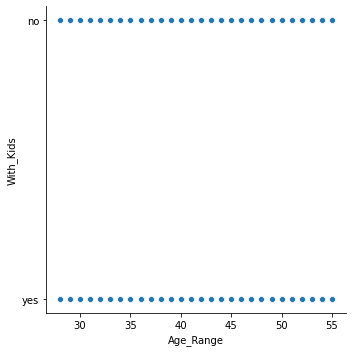

In [25]:
#ax = sns.relplot(x="Age_Range", y="With_Kids", data=cluster)

### Elbow analysis

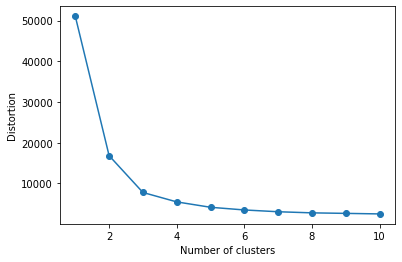

In [27]:
distortions = []

# your codes here...
for i in range(1,11):
    km=KMeans(
        n_clusters=i,
        init='random',
        n_init=10,
        max_iter=300,
        tol=1e-4,
        random_state=0
    )
    km.fit(cluster_dum)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

##conclusion, use k=2(elbow)

In [33]:
km=KMeans(n_clusters=3,random_state=1)
km.fit(cluster_dum)

cluster_vis=cluster.copy()
cluster_vis['label']=km.labels_



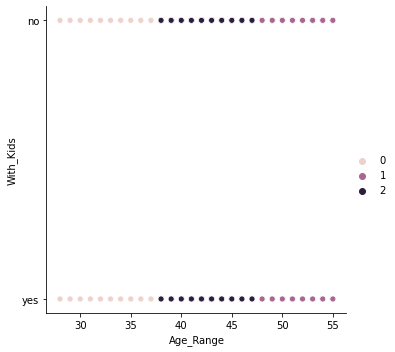

In [34]:
ax = sns.relplot(x="Age_Range", y="With_Kids", hue=cluster_vis.label.tolist(), data=cluster_vis)